# Imports

In [ ]:
!pip3 install --upgrade tensorflow-model-optimization
!pip3 install mat4py

import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import json
import tempfile
import itertools

from google.colab import drive
from mat4py import loadmat


print(tf.__version__)

drive.mount('/content/drive')
%cd /content/drive/My Drive/CGM_prediction_data

     |████████████████████████████████| 174kB 3.5MB/s 
2.3.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/CGM_prediction_data


# Data pre-processing

In [ ]:
def downscale(data, resolution):

    # 10 min resolution.. (data.shape[0], 3, 1440) -> (data.shape[0], 10, 3, 144).. breaks one 3,1440 length trajectory into ten 3,144 length trajectories
    # Use ~12 timesteps -> 2-5 timesteps (Use ~2 hours to predict 20-50 mins)

    return np.mean(data.reshape(data.shape[0], data.shape[1], int(data.shape[2]/resolution), resolution), axis=3)



def process_data(aligned_data, time_horizon, ph):

    # 10 min resolution.. breaks each (3,144) trajectory into (144-ph-time_horizon,3,time_horizon) samples

    data = np.zeros((aligned_data.shape[0] * (aligned_data.shape[2]-ph-time_horizon), aligned_data.shape[1], time_horizon))
    label = np.zeros((aligned_data.shape[0] * (aligned_data.shape[2]-ph-time_horizon), ph))

    count = 0
    for i in range(aligned_data.shape[0]): # for each sample
        for j in range(aligned_data.shape[2]-ph-time_horizon): # TH length sliding window across trajectory
                data[count] = aligned_data[i,:,j:j+time_horizon]
                label[count] = aligned_data[i,0,j+time_horizon:j+time_horizon+ph]
                count+=1     

    return data, label


def load_mpc(time_horizon, ph, resolution, batch): # int, int, int, bool
    
    # Load train data
    g = np.loadtxt('glucose_readings_train.csv', delimiter=',')
    c = np.loadtxt('meals_carbs_train.csv', delimiter=',') 
    it = np.loadtxt('insulin_therapy_train.csv', delimiter=',')

    # Load test data
    g_ = np.loadtxt('glucose_readings_test.csv', delimiter=',')
    c_ = np.loadtxt('meals_carbs_test.csv', delimiter=',')
    it_ = np.loadtxt('insulin_therapy_test.csv', delimiter=',')

    # Time align train & test data
    aligned_train_data = downscale(np.array([(g[i,:], c[i,:], it[i,:]) for i in range(g.shape[0])]), resolution)
    aligned_test_data = downscale(np.array([(g_[i,:], c_[i,:], it_[i,:]) for i in range(g_.shape[0])]), resolution)
    print(aligned_train_data.shape)

    # Break time aligned data into train & test samples
    if batch:
        train_data, train_label = process_data(aligned_train_data, time_horizon, ph)
        test_data, test_label = process_data(aligned_test_data, time_horizon, ph)
    
        return np.swapaxes(train_data,1,2), train_label, np.swapaxes(test_data,1,2), test_label
      
    else:

        return aligned_train_data, aligned_test_data

def load_uva(time_horizon, ph, resolution, batch):

    data = loadmat('uva/sim_results.mat')
    train_data = np.zeros((231,3,1440))
    test_data = np.zeros((99,3,1440))

    # Separate train and test sets.. last 3 records of each patient will be used for testing
    count_train = 0
    count_test = 0
    for i in range(33):
        for j in range(10):

            if j>=7:
                test_data[count_test,0,:] = np.asarray(data['data']['results']['sensor'][count_test+count_train]['signals']['values']).flatten()[:1440]
                test_data[count_test,1,:] = np.asarray(data['data']['results']['CHO'][count_test+count_train]['signals']['values']).flatten()[:1440]
                test_data[count_test,2,:] = np.asarray(data['data']['results']['BOLUS'][count_test+count_train]['signals']['values']).flatten()[:1440] + np.asarray(data['data']['results']['BASAL'][i]['signals']['values']).flatten()[:1440]
                count_test+=1
            else:

                train_data[count_train,0,:] = np.asarray(data['data']['results']['sensor'][count_test+count_train]['signals']['values']).flatten()[:1440]
                train_data[count_train,1,:] = np.asarray(data['data']['results']['CHO'][count_test+count_train]['signals']['values']).flatten()[:1440]
                train_data[count_train,2,:] = np.asarray(data['data']['results']['BOLUS'][count_test+count_train]['signals']['values']).flatten()[:1440] + np.asarray(data['data']['results']['BASAL'][i]['signals']['values']).flatten()[:1440]
                count_train+=1

    train_data = downscale(train_data, resolution)
    test_data = downscale(test_data, resolution)

    if batch: 
        train_data, train_label = process_data(train_data, time_horizon, ph)
        test_data, test_label = process_data(test_data, time_horizon, ph)
    
        return np.swapaxes(train_data,1,2)*0.0555, train_label*0.0555, np.swapaxes(test_data,1,2)*0.0555, test_label*0.0555 # convert to mmol/L

    else:
        
        return train_data, test_data



# Make bidirectional LSTM prunable & define custom metrics

In [ ]:
class PruneBidirectional(tf.keras.layers.Bidirectional, tfmot.sparsity.keras.PrunableLayer):
    def get_prunable_weights(self):
#        print(self.forward_layer._trainable_weights)
#        print(self.backward_layer._trainable_weights)
#        print(len(self.get_trainable_weights()))
#        print(self.get_weights()[0], self.get_weights()[0].shape)
#        return self.get_weights()
        return self.trainable_weights

def loss_metric1(y_true, y_pred):
    loss = tf.keras.losses.MeanSquaredError()
    return loss(y_true[:,0], y_pred[:,0])

def loss_metric2(y_true, y_pred):
    loss = tf.keras.losses.MeanSquaredError()
    return loss(y_true[:,1], y_pred[:,1])

def loss_metric3(y_true, y_pred):
    loss = tf.keras.losses.MeanSquaredError()
    return loss(y_true[:,2], y_pred[:,2])

def loss_metric4(y_true, y_pred):
    loss = tf.keras.losses.MeanSquaredError()
    return loss(y_true[:,3], y_pred[:,3])

def loss_metric5(y_true, y_pred):
    loss = tf.keras.losses.MeanSquaredError()    
    return loss(y_true[:,4], y_pred[:,4])

def loss_metric6(y_true, y_pred):
    loss = tf.keras.losses.MeanSquaredError()
    return loss(y_true[:,5], y_pred[:,5])

def bilstm(ph, training):

    inp = tf.keras.Input(shape=(train_data.shape[1], train_data.shape[2]))
    model = PruneBidirectional(tf.keras.layers.LSTM(200, return_sequences=True))(inp)
    model = tf.keras.layers.Dropout(rate=0.5)(model, training=training)
    model = PruneBidirectional(tf.keras.layers.LSTM(200, return_sequences=True))(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model, training=training)
    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Dense(ph, activation=None)(model)

    x = tf.keras.Model(inputs=inp, outputs=model)

    x.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), loss_metric1, loss_metric2, loss_metric3, loss_metric4, loss_metric5, loss_metric6])
    
    return x 

def crnn(ph, training):
  
    inp = tf.keras.Input(shape=(train_data.shape[1], train_data.shape[2]))
    model = tf.keras.layers.Conv1D(256, 4, activation='relu', padding='same')(inp)
    model = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model, training=training)
    model = tf.keras.layers.Conv1D(512, 4, activation='relu', padding='same')(model)
    model = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model, training=training)
    model = tf.keras.layers.LSTM(200, return_sequences=True)(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model, training=training)
    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Dense(ph, activation=None)(model)

    x = tf.keras.Model(inputs=inp, outputs=model)

    x.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), loss_metric1, loss_metric2, loss_metric3, loss_metric4, loss_metric5, loss_metric6])
    
    return x


# Custom callback to save pruning results

In [ ]:
# Custom sparsity callback
import re
import csv

class SparsityCallback(tf.keras.callbacks.Callback):##tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):

        non_trainable = [i.name for i in self.model.non_trainable_weights]
        masks = []
        for i in range(len(non_trainable)):
            if re.match('(.*)mask(.*)', non_trainable[i]):
                masks.append(self.model.non_trainable_weights[i].numpy())
        masks = [i.flatten() for i in masks]
        masks = np.concatenate(masks).ravel()
        print('\n', np.count_nonzero(masks), 1-(np.count_nonzero(masks)/float(masks.shape[0])))

        with open('saved_models/uva_bilstm_sparsity.csv','ab') as f: #uva_crnn_sparisty.csv, uva_lstm_sparsity.csv, uva_bilstm_sparsity.csv
            np.savetxt(f,np.asarray([1-(np.count_nonzero(masks)/float(masks.shape[0]))]))
#            csv_writer = csv.writer(f)
#            csv_writer.writerow(str(1-(np.count_nonzero(masks)/float(masks.shape[0]))))#,delimiter=',')
            f.close()
#        print(np.concatenate(masks).ravel(), np.concatenate(masks).ravel().shape)





# Prune MPC generated models

## CRNN

In [ ]:
# pruning crnn

%load_ext tensorboard

PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 32
EPOCHS = 50
BATCH = True # indicates whether to convert data into batches
training = True

train_data, train_label, test_data, test_label = load_mpc(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = tf.keras.models.load_model('saved_models/mpc_guided_crnn.h5',custom_objects={'loss_metric1':loss_metric1, 'loss_metric2':loss_metric2, 'loss_metric3':loss_metric3, 'loss_metric4':loss_metric4,'loss_metric5':loss_metric5,'loss_metric6':loss_metric6})

#model = bilstm(PH, training)

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.98,
                                                               begin_step=2997,
                                                               end_step=2997*EPOCHS,
                                                               frequency=2977)
}

print(model.summary())

logdir = tempfile.mkdtemp()
print(logdir)

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  SparsityCallback()
]

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), loss_metric1, loss_metric2, loss_metric3, loss_metric4, loss_metric5, loss_metric6])

print(model_for_pruning.summary())

pruned_crnn = model_for_pruning.fit(x=train_data,
                                      y=train_label,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      validation_data=(test_data, test_label),
                                      callbacks=callbacks)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_mpc_guided_crnn.h5', include_optimizer=False)

!ls saved_models

#print(pruned_model.summary())

#%tensorboard --logdir={logdir}

#model.save('saved_models/pruned_mpc_guided_bilstm.h5')
json.dump(pruned_crnn.history, open('saved_models/pruned_mpc_guided_crnn_history', 'w'))

#!ls saved_models

#%tensorboard --logdir={log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
(756, 3, 144)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 3)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 256)           3328      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 512)           524800    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 512)           0         
________________

## LSTM

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 32
EPOCHS = 50
BATCH = True # indicates whether to convert data into batches
training = True

train_data, train_label, test_data, test_label = load_mpc(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = tf.keras.models.load_model('saved_models/mpc_guided_lstm.h5',custom_objects={'loss_metric1':loss_metric1, 'loss_metric2':loss_metric2, 'loss_metric3':loss_metric3, 'loss_metric4':loss_metric4,'loss_metric5':loss_metric5,'loss_metric6':loss_metric6})

#model = bilstm(PH, training)

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.98,
                                                               begin_step=2997,
                                                               end_step=2997*EPOCHS,
                                                               frequency=2977)
}

print(model.summary())

logdir = tempfile.mkdtemp()
print(logdir)

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  SparsityCallback()
]

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), loss_metric1, loss_metric2, loss_metric3, loss_metric4, loss_metric5, loss_metric6])

print(model_for_pruning.summary())

pruned_lstm = model_for_pruning.fit(x=train_data,
                                      y=train_label,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      validation_data=(test_data, test_label),
                                      callbacks=callbacks)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_mpc_guided_lstm.h5', include_optimizer=False)
json.dump(pruned_lstm.history, open('saved_models/pruned_mpc_guided_lstm_history', 'w'))

!ls saved_models

(756, 3, 144)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 3)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 200)           163200    
_________________________________________________________________
dropout (Dropout)            (None, 12, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 200)           320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 

## Bidirectional LSTM

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 32
EPOCHS = 150
BATCH = True # indicates whether to convert data into batches
training = True

train_data, train_label, test_data, test_label = load_mpc(TIME_HORIZON, PH, RESOLUTION, BATCH)

#model = tf.keras.models.load_model('saved_models/mpc_guided_lstm.h5',custom_objects={'loss_metric1':loss_metric1, 'loss_metric2':loss_metric2, 'loss_metric3':loss_metric3, 'loss_metric4':loss_metric4,'loss_metric5':loss_metric5,'loss_metric6':loss_metric6})

model = bilstm(PH, training)

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.98,
                                                               begin_step=2997*100,
                                                               end_step=2997*EPOCHS,
                                                               frequency=2977)
}

print(model.summary())

logdir = tempfile.mkdtemp()
print(logdir)

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  SparsityCallback()
]

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), loss_metric1, loss_metric2, loss_metric3, loss_metric4, loss_metric5, loss_metric6])

print(model_for_pruning.summary())

pruned_lstm = model_for_pruning.fit(x=train_data,
                                      y=train_label,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      validation_data=(test_data, test_label),
                                      callbacks=callbacks)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_mpc_guided_bilstm.h5', include_optimizer=False)
json.dump(pruned_lstm.history, open('saved_models/pruned_mpc_guided_bilstm_history', 'w'))

!ls saved_models

(756, 3, 144)
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 12, 3)]           0         
_________________________________________________________________
prune_bidirectional_18 (Prun (None, 12, 400)           326400    
_________________________________________________________________
dropout_18 (Dropout)         (None, 12, 400)           0         
_________________________________________________________________
prune_bidirectional_19 (Prun (None, 12, 400)           961600    
_________________________________________________________________
dropout_19 (Dropout)         (None, 12, 400)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 6) 

# MPC Pruning results

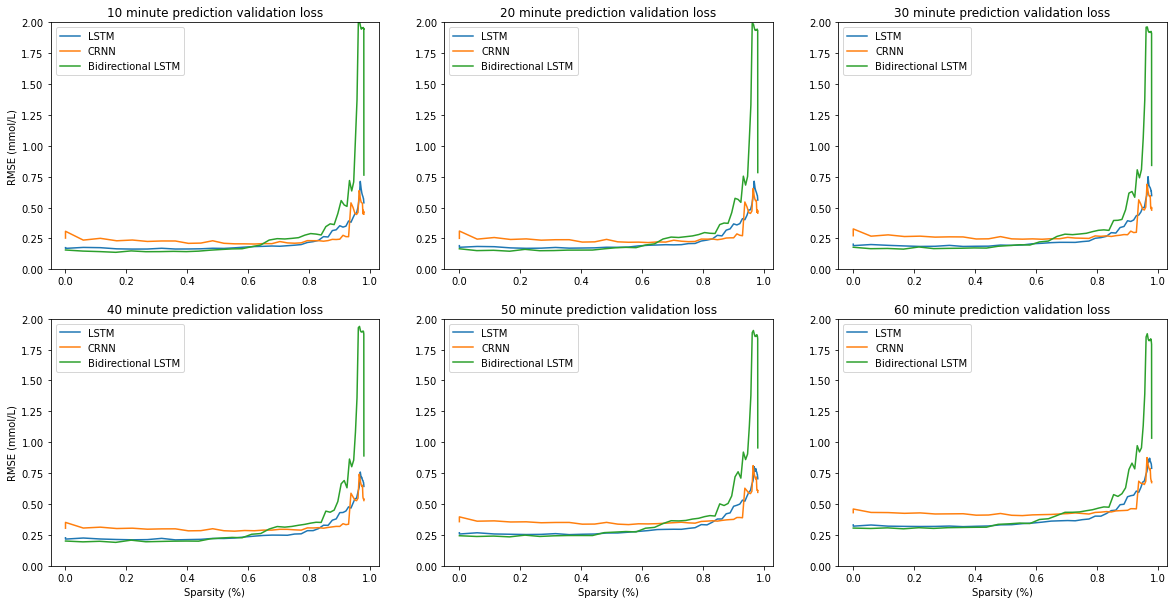

In [ ]:
lstm_val_loss_10 = json.load(open('saved_models/pruned_mpc_guided_lstm_history'))['val_loss_metric1']
lstm_val_loss_20 = json.load(open('saved_models/pruned_mpc_guided_lstm_history'))['val_loss_metric2']
lstm_val_loss_30 = json.load(open('saved_models/pruned_mpc_guided_lstm_history'))['val_loss_metric3']
lstm_val_loss_40 = json.load(open('saved_models/pruned_mpc_guided_lstm_history'))['val_loss_metric4']
lstm_val_loss_50 = json.load(open('saved_models/pruned_mpc_guided_lstm_history'))['val_loss_metric5']
lstm_val_loss_60 = json.load(open('saved_models/pruned_mpc_guided_lstm_history'))['val_loss_metric6']

crnn_val_loss_10 = json.load(open('saved_models/pruned_mpc_guided_crnn_history'))['val_loss_metric1']
crnn_val_loss_20 = json.load(open('saved_models/pruned_mpc_guided_crnn_history'))['val_loss_metric2']
crnn_val_loss_30 = json.load(open('saved_models/pruned_mpc_guided_crnn_history'))['val_loss_metric3']
crnn_val_loss_40 = json.load(open('saved_models/pruned_mpc_guided_crnn_history'))['val_loss_metric4']
crnn_val_loss_50 = json.load(open('saved_models/pruned_mpc_guided_crnn_history'))['val_loss_metric5']
crnn_val_loss_60 = json.load(open('saved_models/pruned_mpc_guided_crnn_history'))['val_loss_metric6']

bilstm_val_loss_10 = json.load(open('saved_models/pruned_mpc_guided_bilstm_history'))['val_loss_metric1'][100:]
bilstm_val_loss_20 = json.load(open('saved_models/pruned_mpc_guided_bilstm_history'))['val_loss_metric2'][100:]
bilstm_val_loss_30 = json.load(open('saved_models/pruned_mpc_guided_bilstm_history'))['val_loss_metric3'][100:]
bilstm_val_loss_40 = json.load(open('saved_models/pruned_mpc_guided_bilstm_history'))['val_loss_metric4'][100:]
bilstm_val_loss_50 = json.load(open('saved_models/pruned_mpc_guided_bilstm_history'))['val_loss_metric5'][100:]
bilstm_val_loss_60 = json.load(open('saved_models/pruned_mpc_guided_bilstm_history'))['val_loss_metric6'][100:]

x_crnn = np.genfromtxt('saved_models/crnn_sparsity.csv')
x_lstm = np.genfromtxt('saved_models/lstm_sparsity.csv')
x_bilstm = np.genfromtxt('saved_models/bilstm_sparsity.csv')[100:]

fig, axes = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (20,10)

axes[0,0].plot(x_lstm, np.sqrt(lstm_val_loss_10), label='LSTM')
axes[0,1].plot(x_lstm, np.sqrt(lstm_val_loss_20), label='LSTM')
axes[0,2].plot(x_lstm, np.sqrt(lstm_val_loss_30), label='LSTM')
axes[1,0].plot(x_lstm, np.sqrt(lstm_val_loss_40), label='LSTM')
axes[1,1].plot(x_lstm, np.sqrt(lstm_val_loss_50), label='LSTM')
axes[1,2].plot(x_lstm, np.sqrt(lstm_val_loss_60), label='LSTM')

axes[0,0].plot(x_crnn, np.sqrt(crnn_val_loss_10), label='CRNN')
axes[0,1].plot(x_crnn, np.sqrt(crnn_val_loss_20), label='CRNN')
axes[0,2].plot(x_crnn, np.sqrt(crnn_val_loss_30), label='CRNN')
axes[1,0].plot(x_crnn, np.sqrt(crnn_val_loss_40), label='CRNN')
axes[1,1].plot(x_crnn, np.sqrt(crnn_val_loss_50), label='CRNN')
axes[1,2].plot(x_crnn, np.sqrt(crnn_val_loss_60), label='CRNN')

axes[0,0].plot(x_bilstm, np.sqrt(bilstm_val_loss_10), label='Bidirectional LSTM')
axes[0,1].plot(x_bilstm, np.sqrt(bilstm_val_loss_20), label='Bidirectional LSTM')
axes[0,2].plot(x_bilstm, np.sqrt(bilstm_val_loss_30), label='Bidirectional LSTM')
axes[1,0].plot(x_bilstm, np.sqrt(bilstm_val_loss_40), label='Bidirectional LSTM')
axes[1,1].plot(x_bilstm, np.sqrt(bilstm_val_loss_50), label='Bidirectional LSTM')
axes[1,2].plot(x_bilstm, np.sqrt(bilstm_val_loss_60), label='Bidirectional LSTM')

axes[0,0].title.set_text('10 minute prediction validation loss')
axes[0,1].title.set_text('20 minute prediction validation loss')
axes[0,2].title.set_text('30 minute prediction validation loss')
axes[1,0].title.set_text('40 minute prediction validation loss')
axes[1,1].title.set_text('50 minute prediction validation loss')
axes[1,2].title.set_text('60 minute prediction validation loss')

axes[0,0].set_ylabel('RMSE (mmol/L)')
axes[1,0].set_ylabel('RMSE (mmol/L)')
axes[1,0].set_xlabel('Sparsity (%)')
axes[1,1].set_xlabel('Sparsity (%)')
axes[1,2].set_xlabel('Sparsity (%)')

axes[0,0].legend()
axes[0,1].legend()
axes[0,2].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[1,2].legend()

#plt.rcParams["figure.figsize"] = (20,10)
custom_ylim = (0,2)
plt.setp(axes, ylim=custom_ylim)
plt.show()

# Prune UVA Padova models

## CRNN

In [ ]:
# pruning crnn

%load_ext tensorboard

PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 32
EPOCHS = 50
BATCH = True # indicates whether to convert data into batches
training = True

train_data, train_label, test_data, test_label = load_uva(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = tf.keras.models.load_model('saved_models/uva_padova_crnn.h5',custom_objects={'loss_metric1':loss_metric1, 'loss_metric2':loss_metric2, 'loss_metric3':loss_metric3, 'loss_metric4':loss_metric4,'loss_metric5':loss_metric5,'loss_metric6':loss_metric6})

#model = bilstm(PH, training)

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.98,
                                                               begin_step=910,
                                                               end_step=910*EPOCHS,
                                                               frequency=910)
}

print(model.summary())

logdir = tempfile.mkdtemp()
print(logdir)

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  SparsityCallback()
]

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), loss_metric1, loss_metric2, loss_metric3, loss_metric4, loss_metric5, loss_metric6])

print(model_for_pruning.summary())

pruned_crnn = model_for_pruning.fit(x=train_data,
                                      y=train_label,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      validation_data=(test_data, test_label),
                                      callbacks=callbacks)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_uva_padova_crnn.h5', include_optimizer=False)

!ls saved_models

#print(pruned_model.summary())

#%tensorboard --logdir={logdir}

#model.save('saved_models/pruned_mpc_guided_bilstm.h5')
json.dump(pruned_crnn.history, open('saved_models/pruned_uva_padova_crnn_history', 'w'))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 12, 3)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 256)           3328      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 256)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 512)           524800    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 12, 512)           0         
______________________________

## LSTM

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 32
EPOCHS = 50
BATCH = True # indicates whether to convert data into batches
training = True

train_data, train_label, test_data, test_label = load_uva(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = tf.keras.models.load_model('saved_models/uva_padova_lstm.h5',custom_objects={'loss_metric1':loss_metric1, 'loss_metric2':loss_metric2, 'loss_metric3':loss_metric3, 'loss_metric4':loss_metric4,'loss_metric5':loss_metric5,'loss_metric6':loss_metric6})

#model = bilstm(PH, training)

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.98,
                                                               begin_step=910,
                                                               end_step=910*EPOCHS,
                                                               frequency=910)
}

print(model.summary())

logdir = tempfile.mkdtemp()
print(logdir)

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  SparsityCallback()
]

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), loss_metric1, loss_metric2, loss_metric3, loss_metric4, loss_metric5, loss_metric6])

print(model_for_pruning.summary())

pruned_lstm = model_for_pruning.fit(x=train_data,
                                      y=train_label,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      validation_data=(test_data, test_label),
                                      callbacks=callbacks)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_uva_padova_lstm.h5', include_optimizer=False)
json.dump(pruned_lstm.history, open('saved_models/pruned_uva_padova_lstm_history', 'w'))

!ls saved_models

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 12, 3)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 12, 200)           163200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 200)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 12, 200)           320800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 200)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 12, 200)           320800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 200)          

## BiLSTM

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 32
EPOCHS = 150
BATCH = True # indicates whether to convert data into batches
training = True

train_data, train_label, test_data, test_label = load_uva(TIME_HORIZON, PH, RESOLUTION, BATCH)

#model = tf.keras.models.load_model('saved_models/mpc_guided_lstm.h5',custom_objects={'loss_metric1':loss_metric1, 'loss_metric2':loss_metric2, 'loss_metric3':loss_metric3, 'loss_metric4':loss_metric4,'loss_metric5':loss_metric5,'loss_metric6':loss_metric6})

model = bilstm(PH, training)

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.98,
                                                               begin_step=910*100,
                                                               end_step=910*EPOCHS,
                                                               frequency=910)
}

print(model.summary())

logdir = tempfile.mkdtemp()
print(logdir)

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  SparsityCallback()
]

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), loss_metric1, loss_metric2, loss_metric3, loss_metric4, loss_metric5, loss_metric6])

print(model_for_pruning.summary())

pruned_lstm = model_for_pruning.fit(x=train_data,
                                      y=train_label,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      validation_data=(test_data, test_label),
                                      callbacks=callbacks)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_uva_padova_bilstm.h5', include_optimizer=False)
json.dump(pruned_lstm.history, open('saved_models/pruned_uva_padova_bilstm_history', 'w'))

!ls saved_models

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 12, 3)]           0         
_________________________________________________________________
prune_bidirectional_22 (Prun (None, 12, 400)           326400    
_________________________________________________________________
dropout_22 (Dropout)         (None, 12, 400)           0         
_________________________________________________________________
prune_bidirectional_23 (Prun (None, 12, 400)           961600    
_________________________________________________________________
dropout_23 (Dropout)         (None, 12, 400)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)               

# UVA Padova Pruning results

(50,) (50,) (50,)


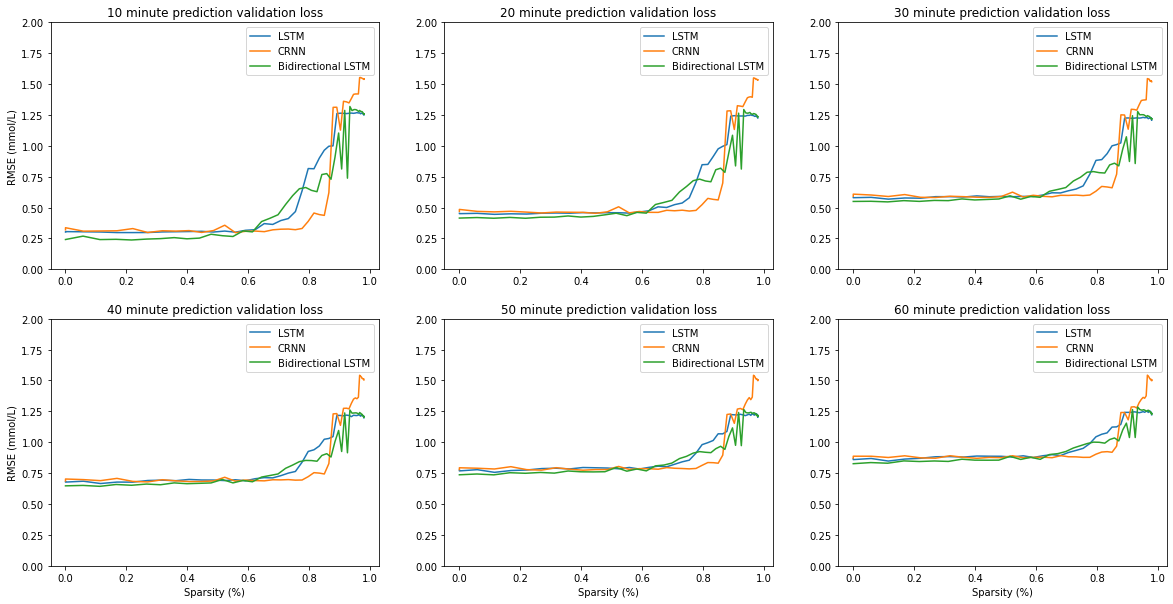

In [ ]:
lstm_val_loss_10 = json.load(open('saved_models/pruned_uva_padova_lstm_history'))['val_loss_metric1']
lstm_val_loss_20 = json.load(open('saved_models/pruned_uva_padova_lstm_history'))['val_loss_metric2']
lstm_val_loss_30 = json.load(open('saved_models/pruned_uva_padova_lstm_history'))['val_loss_metric3']
lstm_val_loss_40 = json.load(open('saved_models/pruned_uva_padova_lstm_history'))['val_loss_metric4']
lstm_val_loss_50 = json.load(open('saved_models/pruned_uva_padova_lstm_history'))['val_loss_metric5']
lstm_val_loss_60 = json.load(open('saved_models/pruned_uva_padova_lstm_history'))['val_loss_metric6']

crnn_val_loss_10 = json.load(open('saved_models/pruned_uva_padova_crnn_history'))['val_loss_metric1']
crnn_val_loss_20 = json.load(open('saved_models/pruned_uva_padova_crnn_history'))['val_loss_metric2']
crnn_val_loss_30 = json.load(open('saved_models/pruned_uva_padova_crnn_history'))['val_loss_metric3']
crnn_val_loss_40 = json.load(open('saved_models/pruned_uva_padova_crnn_history'))['val_loss_metric4']
crnn_val_loss_50 = json.load(open('saved_models/pruned_uva_padova_crnn_history'))['val_loss_metric5']
crnn_val_loss_60 = json.load(open('saved_models/pruned_uva_padova_crnn_history'))['val_loss_metric6']

bilstm_val_loss_10 = json.load(open('saved_models/pruned_uva_padova_bilstm_history'))['val_loss_metric1'][100:]
bilstm_val_loss_20 = json.load(open('saved_models/pruned_uva_padova_bilstm_history'))['val_loss_metric2'][100:]
bilstm_val_loss_30 = json.load(open('saved_models/pruned_uva_padova_bilstm_history'))['val_loss_metric3'][100:]
bilstm_val_loss_40 = json.load(open('saved_models/pruned_uva_padova_bilstm_history'))['val_loss_metric4'][100:]
bilstm_val_loss_50 = json.load(open('saved_models/pruned_uva_padova_bilstm_history'))['val_loss_metric5'][100:]
bilstm_val_loss_60 = json.load(open('saved_models/pruned_uva_padova_bilstm_history'))['val_loss_metric6'][100:]

x_crnn = np.genfromtxt('saved_models/uva_crnn_sparsityv2.csv')#[6:]
x_lstm = np.genfromtxt('saved_models/uva_lstm_sparsity.csv')
x_bilstm = np.genfromtxt('saved_models/uva_bilstm_sparsityv2.csv')[100:]
print(x_crnn.shape, x_lstm.shape, x_bilstm.shape)

fig, axes = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (20,10)

axes[0,0].plot(x_lstm, np.sqrt(lstm_val_loss_10), label='LSTM')
axes[0,1].plot(x_lstm, np.sqrt(lstm_val_loss_20), label='LSTM')
axes[0,2].plot(x_lstm, np.sqrt(lstm_val_loss_30), label='LSTM')
axes[1,0].plot(x_lstm, np.sqrt(lstm_val_loss_40), label='LSTM')
axes[1,1].plot(x_lstm, np.sqrt(lstm_val_loss_50), label='LSTM')
axes[1,2].plot(x_lstm, np.sqrt(lstm_val_loss_60), label='LSTM')

axes[0,0].plot(x_crnn, np.sqrt(crnn_val_loss_10), label='CRNN')
axes[0,1].plot(x_crnn, np.sqrt(crnn_val_loss_20), label='CRNN')
axes[0,2].plot(x_crnn, np.sqrt(crnn_val_loss_30), label='CRNN')
axes[1,0].plot(x_crnn, np.sqrt(crnn_val_loss_40), label='CRNN')
axes[1,1].plot(x_crnn, np.sqrt(crnn_val_loss_50), label='CRNN')
axes[1,2].plot(x_crnn, np.sqrt(crnn_val_loss_60), label='CRNN')

axes[0,0].plot(x_bilstm, np.sqrt(bilstm_val_loss_10), label='Bidirectional LSTM')
axes[0,1].plot(x_bilstm, np.sqrt(bilstm_val_loss_20), label='Bidirectional LSTM')
axes[0,2].plot(x_bilstm, np.sqrt(bilstm_val_loss_30), label='Bidirectional LSTM')
axes[1,0].plot(x_bilstm, np.sqrt(bilstm_val_loss_40), label='Bidirectional LSTM')
axes[1,1].plot(x_bilstm, np.sqrt(bilstm_val_loss_50), label='Bidirectional LSTM')
axes[1,2].plot(x_bilstm, np.sqrt(bilstm_val_loss_60), label='Bidirectional LSTM')

axes[0,0].title.set_text('10 minute prediction validation loss')
axes[0,1].title.set_text('20 minute prediction validation loss')
axes[0,2].title.set_text('30 minute prediction validation loss')
axes[1,0].title.set_text('40 minute prediction validation loss')
axes[1,1].title.set_text('50 minute prediction validation loss')
axes[1,2].title.set_text('60 minute prediction validation loss')

axes[0,0].set_ylabel('RMSE (mmol/L)')
axes[1,0].set_ylabel('RMSE (mmol/L)')
axes[1,0].set_xlabel('Sparsity (%)')
axes[1,1].set_xlabel('Sparsity (%)')
axes[1,2].set_xlabel('Sparsity (%)')

axes[0,0].legend()
axes[0,1].legend()
axes[0,2].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[1,2].legend()

#plt.rcParams["figure.figsize"] = (20,10)
custom_ylim = (0,2)
plt.setp(axes, ylim=custom_ylim)
plt.show()